<a href="https://colab.research.google.com/github/Asad808/Computer-Vision-Binary-Classification/blob/main/Horses_vs_Humans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Load External Data into Google Colab**

There are 7 common ways to load external data into Google Colab:



1.   Uploading file through Files explorer
2.   Uploading file using files module
3.   Reading a file from Github
4.   Cloning a Github Repository
5.   Downloading files using Linux wget command
6.   Accessing Google Drive by mounting it locally
7.   Loading Kaggle Datasets

After downloading the datasets (for both training and validation) and unzip and extracting on your system, colab is mounted with google drive. And uploaded to Colab's files.

To dowload datasets for training: https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

To dowload datasets for validation: https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

In [1]:
# Downloaded dataset of horses and humans is upoloaded via google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [55]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   zoom_range = 0.2,
                                   shear_range = 0.2,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True
                                   )
validation_datagen = ImageDataGenerator(rescale= 1./255)
# Flow training images in batches of 64 using train_datagen generator
train_generator =  train_datagen.flow_from_directory("drive/MyDrive/horse-or-human",
                                                     target_size = (150,150),
                                                     batch_size =64, 
                                                     class_mode= "binary")

# Flow training images in batches of 32 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory("drive/MyDrive/validation-horse-or-human",
                                                     target_size = (150,150),
                                                     batch_size =32, 
                                                     class_mode= "binary")

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Sample human image:


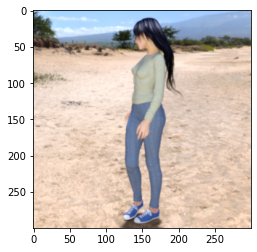


Sample horse image:


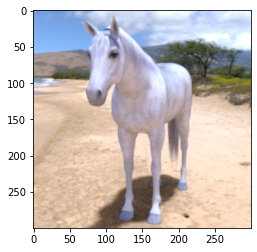

In [25]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
# Base directory contains two subdirectories horse and human/ and each image is 
# saved under the subdirectory related to the class
# it belongs to.
base_dir = "drive/MyDrive/horse-or-human"
human_dir = "drive/MyDrive/horse-or-human/humans"
horse_dir = "drive/MyDrive/horse-or-human/horses"

print("Sample human image:")
plt.imshow(load_img("drive/MyDrive/horse-or-human/humans/human01-00.png"))
plt.show()

print("\nSample horse image:")
plt.imshow(load_img(f"/content/drive/MyDrive/horse-or-human/horses/horse01-0.png"))
plt.show()

In [4]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 

--2022-06-05 10:49:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

inception_v3_weight 100%[===================>]  83.84M   380MB/s    in 0.2s    

2022-06-05 10:49:48 (380 MB/s) - ‘inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [56]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pre_trained_model = InceptionV3(weights = None,
                                 include_top = False,
                                 input_shape = (150,150,3))

pre_trained_model.load_weights(local_weights)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 74, 74, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_376 (Batch  (None, 74, 74, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [57]:
last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output

In [58]:
import tensorflow as tf
from tensorflow.keras import Model

# Flatten the results to feed into a DNN
x = tf.keras.layers.Flatten()(last_output)
# 1024 neuron hidden layer
x = tf.keras.layers.Dense(512, activation = "relu")(x)
 # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(1, activation = "sigmoid")(x)
model = Model(pre_trained_model.input, x)


In [59]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs = {}):
    if logs.get("accuracy") > 0.999:
      print("\n Cancelling training, accuracy reached 99.9%")
      self.model.stop_training = True
callbacks = mycallback()

In [30]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [62]:
model.compile(loss= tf.keras.losses.binary_crossentropy,
               optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
               metrics = ["accuracy"])

In [63]:
history = model.fit(train_generator, epochs = 100, verbose=1, validation_data = validation_generator,
          steps_per_epoch=16, validation_steps = 8, callbacks = callbacks)

Epoch 1/100
16/16 [==============================] - 17s 858ms/step - loss: 2.9994 - accuracy: 0.8359 - val_loss: 0.0461 - val_accuracy: 0.9844
Epoch 2/100
16/16 [==============================] - 12s 826ms/step - loss: 0.0766 - accuracy: 0.9751 - val_loss: 0.0044 - val_accuracy: 0.9961
Epoch 3/100
16/16 [==============================] - 13s 780ms/step - loss: 0.0600 - accuracy: 0.9782 - val_loss: 0.0239 - val_accuracy: 0.9883
Epoch 4/100
16/16 [==============================] - 13s 819ms/step - loss: 0.0463 - accuracy: 0.9823 - val_loss: 4.2120e-04 - val_accuracy: 1.0000
Epoch 5/100
16/16 [==============================] - 12s 780ms/step - loss: 0.2025 - accuracy: 0.9605 - val_loss: 0.0799 - val_accuracy: 0.9766
Epoch 6/100
16/16 [==============================] - 17s 1s/step - loss: 0.0285 - accuracy: 0.9896 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/100
16/16 [==============================] - 14s 899ms/step - loss: 0.0283 - accuracy: 0.9907 - val_loss: 3.4620e-05 - val_accu

In [64]:
# Check the accuracy acheived after number of epochs 
print(f"Your model reached the desired accuracy after {len(history.epoch)} epochs")

Your model reached the desired accuracy after 23 epochs


Run the code below to visualize the accuracy and loss for training and validation.

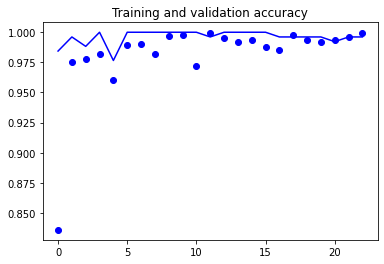

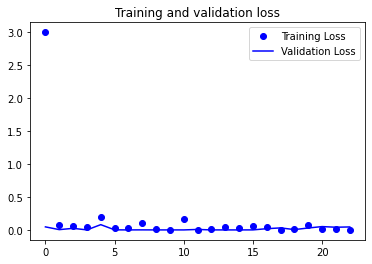

In [65]:
'''Plots the training and validation loss and accuracy from a history object'''
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Here you can download images of horse or human from pixabay.com, and upload below after running the code block to verify the prediction.

In [67]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")
 

Saving horses-g0b4b8089c_640.jpg to horses-g0b4b8089c_640 (1).jpg
Saving cocktail-dress-gebb153e65_640.png to cocktail-dress-gebb153e65_640 (1).png
Saving suit-g246d01448_640.jpg to suit-g246d01448_640 (1).jpg
Saving horse-gf0e93a197_640.jpg to horse-gf0e93a197_640 (1).jpg
Saving iceland-g3656a713b_640.jpg to iceland-g3656a713b_640 (1).jpg
Saving woman-gb4f824b01_640.jpg to woman-gb4f824b01_640 (1).jpg
Saving horse-g503a81471_640.jpg to horse-g503a81471_640 (1).jpg
[8.687865e-28]
horses-g0b4b8089c_640.jpg is a horse
[1.]
cocktail-dress-gebb153e65_640.png is a human
[1.]
suit-g246d01448_640.jpg is a human
[0.00037129]
horse-gf0e93a197_640.jpg is a horse
[1.0900082e-08]
iceland-g3656a713b_640.jpg is a horse
[0.00022654]
woman-gb4f824b01_640.jpg is a horse
[5.1471046e-17]
horse-g503a81471_640.jpg is a horse
